1. Load and Cleanse the Data

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

dataset_path = 'asl_alphabet_train_copy'

if os.path.exists(dataset_path):
    print(f"Directory exists: {dataset_path}")
    # List categories in the dataset directory, excluding non-directory files
    categories = [d for d in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Categories: {categories}")

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            print(f"Category {category} contains {len(os.listdir(category_path))} images.")
else:
    print(f"Directory does not exist: {dataset_path}")

Directory exists: asl_alphabet_train_copy
Categories: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7', '8', '9']
Category 0 contains 1000 images.
Category 1 contains 1000 images.
Category 10 contains 1000 images.
Category 11 contains 1000 images.
Category 12 contains 1000 images.
Category 13 contains 1000 images.
Category 14 contains 1000 images.
Category 15 contains 1000 images.
Category 16 contains 1000 images.
Category 17 contains 1000 images.
Category 18 contains 1000 images.
Category 19 contains 1000 images.
Category 2 contains 1000 images.
Category 20 contains 1000 images.
Category 21 contains 1000 images.
Category 22 contains 1000 images.
Category 23 contains 1000 images.
Category 24 contains 1000 images.
Category 25 contains 1000 images.
Category 26 contains 1000 images.
Category 3 contains 1000 images.
Category 4 contains 1000 images.
Category 5 contains 1000 images.
Category 6 contai

2. Preprocess the Data

In [2]:
# Parameters
image_size = (64, 64)  # Resize images to 64x64
images = []
labels = []

# Load and preprocess images
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:  # Check if the image is loaded correctly
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(category)

# Normalize pixel values
images = np.array(images) / 255.0

# Convert labels to one-hot encoding
labels = pd.get_dummies(labels).values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 21600, Test set size: 5400


3. Build the Object Detection Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

C:\Users\User\anaconda3\envs\ocv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,635 (6.21 MB)

 Trainable params: 1,628,635 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

4. Augment the Data

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

5. Optimize the Object Detection Model

In [5]:
# Train the model
batch_size = 32
epochs = 10

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Epoch 1/10


C:\Users\User\anaconda3\envs\ocv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.0777 - loss: 3.1681 - val_accuracy: 0.3437 - val_loss: 2.1236
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.2709 - loss: 2.3073 - val_accuracy: 0.5365 - val_loss: 1.5229
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.3973 - loss: 1.8280 - val_accuracy: 0.6233 - val_loss: 1.1929
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.4792 - loss: 1.5387 - val_accuracy: 0.7335 - val_loss: 0.8710
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.5402 - loss: 1.3419 - val_accuracy: 0.7678 - val_loss: 0.7369
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.5824 - loss: 1.2191 - val_accuracy: 0.7987 - val_loss: 0.6618
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.6162 - loss: 1.0879 - val_accuracy: 0.7689 - val_loss: 0.6880
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.6458 - loss: 1.0195 - val_accurac

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


<Figure size 1200x800 with 0 Axes>

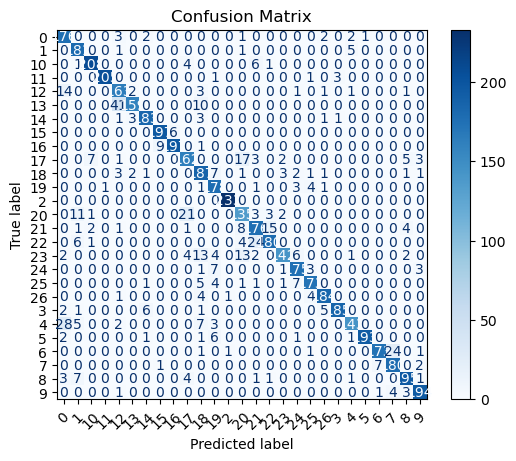

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Calculate overall accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"Overall Accuracy: {accuracy:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       187
           1       0.85      0.96      0.90       188
          10       0.95      0.95      0.95       220
          11       1.00      0.98      0.99       210
          12       0.75      0.88      0.81       186
          13       0.96      0.76      0.85       210
          14       0.94      0.95      0.95       192
          15       0.95      0.97      0.96       203
          16       0.97      0.95      0.96       207
          17       0.83      0.81      0.82       200
          18       0.79      0.89      0.83       210
          19       0.85      0.94      0.89       189
           2       0.99      1.00      1.00       233
          20       0.75      0.77      0.76       176
          21       0.81      0.85      0.83       208
          22       0.90      0.84      0.87       215
          23       0.94      0.75      0.84       189
    

In [10]:
model.save('asl_model.keras')

In [11]:
model = tf.keras.models.load_model('asl_model.keras')